# Predictions with the comparison with baseline

Update 29/Oct/2020  
We now have Round 1's results. We observe that the consensus sequence has very different labels for different plates/rounds. So we decide to normalise to the consensus sequence (before log normalisation and z-normalisation, subtract the mean of each consensus sequence mean in each plate/round). We will call the normalisation methods as **plate normalisation** and **round normalisation** respectively.
Let's see how the predictions look like for different normalisation methods on the following training/testing pairs
- train 80% round 0 and test 20% round 0
- train round 0 and test round 1
- train 80% all data (round 0 + 1) and test the rest

As always, we consider GPR with RBF, one-hot as a baseline model we would like to compare with.
Our model GPR with wd kernel with shift.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Read Data and Set Up

In [2]:
# plate normalisation
plateRep_Path = '../../data/Results_Microplate_partialFalse_normTrue_plateRep_formatSeq_logTrue.csv'
# round normalisation
roundRep_Path = '../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'

plate_df = pd.read_csv(plateRep_Path)
round_df = pd.read_csv(roundRep_Path)

In [3]:
def run_kfold(df,kernel, embedding, train_idx = None, test_idx = None, 
              num_split = 5,num_repeat = 10,s_list = [1],alpha_list= [2],l_list = [6]):
    gpr = GPR_Predictor(df, train_idx = train_idx, test_idx = test_idx, embedding = embedding, kernel_name = kernel)
    result_DataArray_wd = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                          l_list = l_list, s_list = s_list)
    # print(result_DataArray_wd[1].mean(axis = -1).mean(axis=-1))
    return result_DataArray_wd

def run_regression(df,kernel, embedding, train_idx = None, test_idx = None, 
               eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, alpha = 2, eva_on='seqs', title = 'Prediction'):
    # train and test on round 0
    gpr_train_samples = GPR_Predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel, embedding = embedding,     
                                    eva_metric = eva_metric, l = 6, s = 1, alpha = 2, eva_on='seqs')
    gpr_train_samples.regression()
    gpr_train_samples.scatter_plot(title = title)


## Train and Test on Round 0

X train shape:  (851, 20)
X test shape:  (35, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.14131473823189442
Test:  0.9212193583197398
<function r2_score at 0x7fa6de3c48c8>
Train:  0.8249326014047027
Test:  0.1418314053980212


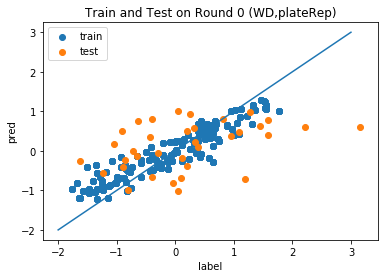

X train shape:  (851, 20)
X test shape:  (35, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.12622806253322547
Test:  0.6967545368659726
<function r2_score at 0x7fa6de3c48c8>
Train:  0.8471213269677741
Test:  0.3107835018531073


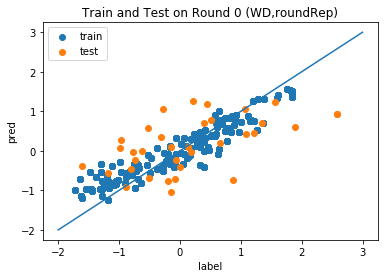

X train shape:  (851, 80)
X test shape:  (35, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.16596520657226688
Test:  0.9614203632778399
<function r2_score at 0x7fa6de3c48c8>
Train:  0.7943944323467583
Test:  0.10438186678931793


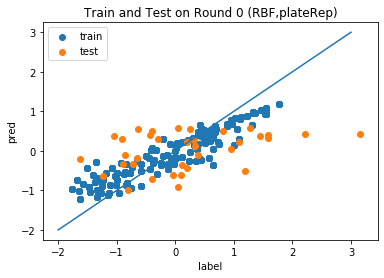

X train shape:  (851, 80)
X test shape:  (35, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.17162572053556102
Test:  0.7303701477703508
<function r2_score at 0x7fa6de3c48c8>
Train:  0.7921388327831624
Test:  0.27753157107301285


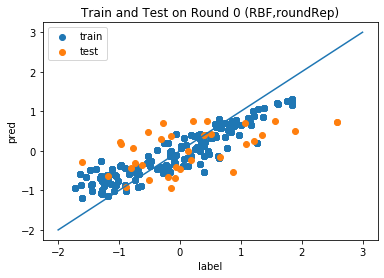

In [4]:
# setting

kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

run_regression(plate_df[plate_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (WD,plateRep)')
run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (WD,roundRep)')

kernel = 'RBF'
embedding = 'onehot'

run_regression(plate_df[plate_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (RBF,plateRep)')
run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (RBF,roundRep)')

## Train on Round 0 and Test on Round 1

X train shape:  (1061, 20)
X test shape:  (89, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.19056875276687998
Test:  0.8892007213774785
<function r2_score at 0x7fa6de3c48c8>
Train:  0.7804746893089717
Test:  -0.024531376647416447


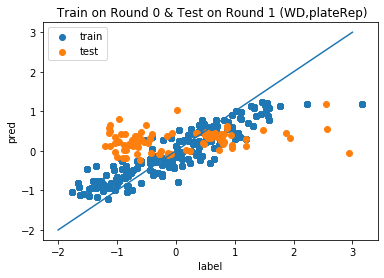

X train shape:  (1061, 20)
X test shape:  (89, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.15574028482236899
Test:  0.8408840848669799
<function r2_score at 0x7fa6de3c48c8>
Train:  0.8208832358674383
Test:  0.031138742515768203


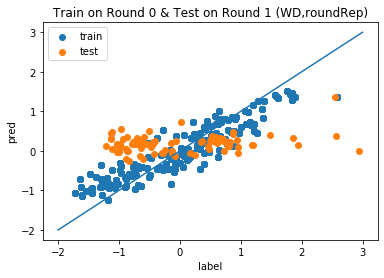

X train shape:  (1061, 80)
X test shape:  (89, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.12666130647813026
Test:  0.7583908397584534
<function r2_score at 0x7fa6de3c48c8>
Train:  0.8540927499737745
Test:  0.126186931235436


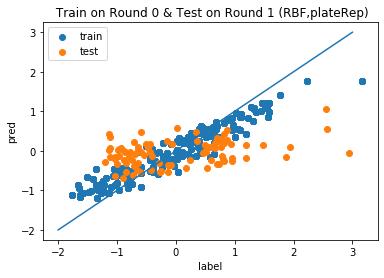

X train shape:  (1061, 80)
X test shape:  (89, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.1737529976424318
Test:  0.760626043081808
<function r2_score at 0x7fa6de3c48c8>
Train:  0.8001668307494006
Test:  0.12361154428071575


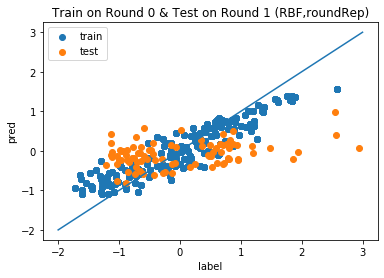

In [5]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

run_regression(plate_df, kernel, embedding, train_idx= plate_df['Plate'] != 'Third_Plate', 
                test_idx= plate_df['Plate'] == 'Third_Plate', title = ' Train on Round 0 & Test on Round 1 (WD,plateRep)')
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Third_Plate', 
                test_idx= round_df['Plate'] == 'Third_Plate',  title = 'Train on Round 0 & Test on Round 1 (WD,roundRep)')

kernel = 'RBF'
embedding = 'onehot'

run_regression(plate_df, kernel, embedding, train_idx= plate_df['Plate'] != 'Third_Plate', 
                test_idx= plate_df['Plate'] == 'Third_Plate', title = ' Train on Round 0 & Test on Round 1 (RBF,plateRep)')
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Third_Plate', 
                test_idx= round_df['Plate'] == 'Third_Plate',  title = 'Train on Round 0 & Test on Round 1 (RBF,roundRep)')

# train and test on round 0
# gpr_train_samples = GPR_Predictor(df[df['Plate'] != 'Third_Plate'], kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, l = 6, s = 1, alpha = 2, eva_on='seqs')

# train on round 0 (plate 1 and 2) and test on round 1 (plate 3)
# gpr_train_samples = GPR_Predictor(df, train_idx= df['Plate'] != 'Third_Plate', test_idx= df['Plate'] == 'Third_Plate', 
#                    kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
#                    l = 6, s = 1, alpha = 2, eva_on='seqs')

## Train and Test on All Rounds Data

X train shape:  (1210, 20)
X test shape:  (53, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.2578324722003237
Test:  0.5376504534854858
<function r2_score at 0x7fa6de3c48c8>
Train:  0.7101999300137349
Test:  0.2730434211832341


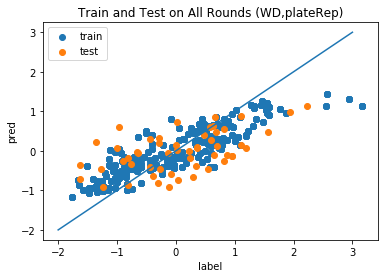

X train shape:  (1210, 20)
X test shape:  (53, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.22461046479857416
Test:  0.4909462882179622
<function r2_score at 0x7fa6de3c48c8>
Train:  0.7466497545676517
Test:  0.35285338580488945


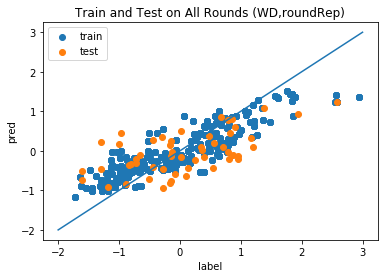

X train shape:  (1210, 80)
X test shape:  (53, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.05856644235693651
Test:  0.7468651731060779
<function r2_score at 0x7fa6de3c48c8>
Train:  0.9341721430623374
Test:  -0.009835567995560401


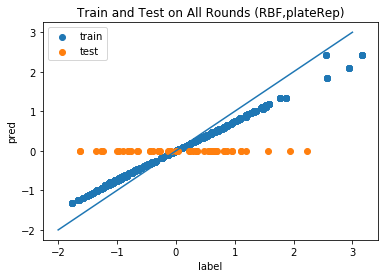

X train shape:  (1210, 80)
X test shape:  (53, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fa6de3c46a8>
Train:  0.14909983555478734
Test:  0.5069295294252436
<function r2_score at 0x7fa6de3c48c8>
Train:  0.8318222618629836
Test:  0.33178488874240886


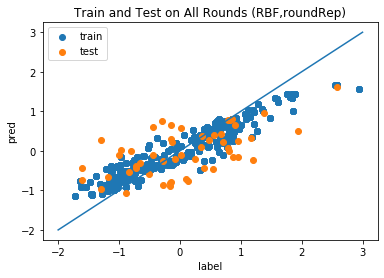

In [6]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

run_regression(plate_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,plateRep)')
run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,roundRep)')

kernel = 'RBF'
embedding = 'onehot'

run_regression(plate_df, kernel, embedding, title = 'Train and Test on All Rounds (RBF,plateRep)')
run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (RBF,roundRep)')

In [7]:
# kernel = 'RBF'
# embedding = 'onehot'
# eva_metric = [mean_squared_error, r2_score]

# # gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
# #                    alpha = 2, eva_on='seqs')

# # train and test on round 0
# gpr_train_samples = GPR_Predictor(df[df['Plate'] != 'Third_Plate'], kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, alpha = 2, eva_on='seqs')

# # train on round 0 (plate 1 and 2) and test on round 1 (plate 3)
# # gpr_train_samples = GPR_Predictor(df, train_idx= df['Plate'] != 'Third_Plate', test_idx= df['Plate'] == 'Third_Plate', 
# #                    kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
# #                    l = 6, s = 1, alpha = 2, eva_on='seqs')
# gpr_train_samples.regression()
# gpr_train_samples.scatter_plot()

## Conclusion

For train and test on round 0 or all rounds, WD is better than baseline and the prediction looks reasonable (test error is still big but at least show correct pattern). However, the generalisation between round 0 and round 1 is bad. For train on round 0 and test on round 1, WD is even worse than baseline. Both WD and baseline predictions look in the wrong range and pattern.
Several possible reasons:
- round 1 are areas we do not have enough information from round 0 (need to check by tsne?)
- normalisation over different rounds still problematic.
- in round 0 we have lots of sequences where the noncore part is not the same as our design space. The predictor trained on round 0 data could be biased.
- note the prediction is different from we have in the design file. Except for different normalisation methods for labels, the normalisation over kernels is different. For the design one, the kernel is normalised over all known sequences and design space; for this notebook, the kernel is normalised over input train and test data.
